# Mixing Score
The purpose of this notebook is to calculate the mixing score of a sample. Defined originally as a way to quantify the degree of mixing between specifically tumor and immune cells [(Keren et al , Cell 2018)](https://www.cell.com/cell/fulltext/S0092-8674(18)31100-0), the mixing score below has been adapted to analyze any two cell populations provided.

In [ ]:
import os

import pandas as pd
import seaborn
from alpineer import misc_utils

import ark.settings as settings
from ark.analysis import spatial_analysis_utils
from ark.analysis.neighborhood_analysis import (compute_cell_ratios, compute_mixing_score, create_neighborhood_matrix)
from ark.utils import example_dataset

## 0. Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook, as well as the data previously generated by segmentation and cell clustering.

In [ ]:
base_dir = '/Volumes/Shared/Noah Greenwald/TONIC_Cohort'

If you would like to first try running this notebook with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

In [ ]:
# example_dataset.get_example_dataset(dataset="post_clustering", save_dir = base_dir, overwrite_existing = False)

## 1. Set Up
### Define paths
* `cell_table_path`: the path to the cell table that contains columns for fov, cell label, and cell phenotype ([generated from 3_Pixie_Cluster_Cells.ipynb](./3_Pixie_Cluster_Cells.ipynb))
* `segmentation_dir`: the path to the directory containing your segmentations ([generated from 1_Segment_Image_Data.ipynb](./1_Segment_Image_Data.ipynb))

For the following directories, if they were not previously generated by either [example_neighborhood_analysis_script.ipynb](./example_neighborhood_analysis_script.ipynb) or [example_pairwise_spatial_enrichment.ipynb](./example_pairwise_spatial_enrichment.ipynb), they will be created below.
* `spatial_analysis_dir`: the path to the directory contatining spatial analysis output, **will create a new folder if it doesn't exist**
* `dist_mat_dir`: the path to directory containing the distance matrices for each FOV
* `neighbors_mat_dir`: the path to directory containing the neighborhood matrix for your data, will generate below if needed similar to `dist_mat_dir`

In [ ]:
cell_table_path = os.path.join(base_dir, "analysis_files/cell_table_clusters.csv")
segmentation_dir = os.path.join(base_dir, "segmentation_data/deepcell_output")

spatial_analysis_dir = os.path.join(base_dir, "intermediate_files/spatial_analysis")
dist_mat_dir = os.path.join(base_dir, "intermediate_files/spatial_analysis", "dist_mats")
neighbors_mat_dir = os.path.join(spatial_analysis_dir, "neighborhood_mats")

# new directory to store mixing score results
mixing_score_dir = os.path.join(spatial_analysis_dir, "mixing_score")

In [ ]:
# create the dist_mat_dir directory if it doesn't exist
if not os.path.exists(dist_mat_dir):
    os.makedirs(dist_mat_dir)
    spatial_analysis_utils.calc_dist_matrix(segmentation_dir, dist_mat_dir)
    
# create the neighbors_mat_dir directory if it doesn't exist
if not os.path.exists(neighbors_mat_dir):
    os.makedirs(neighbors_mat_dir)
    
# create mixing directory
if not os.path.exists(mixing_score_dir):
    os.makedirs(mixing_score_dir)

### Read in data from the cell table

In [ ]:
all_data = pd.read_csv(cell_table_path)
all_fovs = all_data[settings.FOV_ID].unique()

### Define cell populations of interest and compute neighbors matrices

We will now define the neighbors matrix, which will be used as our input for mixing analysis. For each cell in the cell table, count the number of each cell phenotype within a certain distance of that cell. If a cell has no other cells within the distance specfied by `pixel_radius`, that cell is excluded from the analysis.

The neighbors matrix will be saved in the `neighbors_mat_dir`.
- `pixel_radius`: radius used to define the neighbors of each cell
- `cell_type_col`: name of the column in your cell table containing cell phenotypes


In [ ]:
pixel_radius = 50
cell_type_col = 'cell_cluster_broad'

counts_path = os.path.join(neighbors_mat_dir, f"neighborhood_counts-{cell_type_col}_radius{pixel_radius}.csv")
freqs_path = os.path.join(neighbors_mat_dir, f"neighborhood_freqs-{cell_type_col}_radius{pixel_radius}.csv")

**If you have previously generated a neighbors matrix with the `pixel_radius` and `cell_type_col` specified, the data will be loaded in below. Otherwise, a new neighbors matrix will be created.**

In [ ]:
# Check for existing neighbors matrix
if os.path.exists(counts_path) and os.path.exists(freqs_path):
    neighbor_counts = pd.read_csv(counts_path)
    neighbor_freqs = pd.read_csv(freqs_path) 

else:
    print("Generating neighbors matrix.")
    # Create new matrix with the radius and cell column specified above
    neighbor_counts, neighbor_freqs = create_neighborhood_matrix(
        all_data, dist_mat_dir, distlim=pixel_radius, cell_type_col=cell_type_col)

    # Save neighbor matrices
    neighbor_counts.to_csv(counts_path, index=False)
    neighbor_freqs.to_csv(freqs_path, index=False)

## 2. Determining the type of mixing appropriate for your data
### Percent Mixing
The original mixing score calculation described in [(Keren et al , Cell 2018)](https://www.cell.com/cell/fulltext/S0092-8674(18)31100-0) aimed to quantify the mixing of one infiltrating cell population within another. You might want to use this type of scoring if you are primarily concerned with the organization of the `population_1_cells` within a sample (i.e. if these cells tend to cluster together or are spread throughout the sample).

### Homogeneous Mixing
The homogeneous score instead gives insight to more general spatial mixing between two cell populations, without the expectation that one cell type in particular should exhibit specific behavior. This is a symmetrical calculation that will give the same scores for two cell groups, regardless of which is considered `population_1_cells` and which is `population_2_cells`. 

In [ ]:
mixing_type = "homogeneous"   # or "percent"

## 3. Examine ratio of cell populations

When quanifying the amount of mixing in a sample, having a much higher presence of cells from one population compared to the other can produce a misleading score.  Looking at the ratios of cell populations below will help with determining an appropriate limit, so that any samples with ratios above the specified threshold will not be assigned a mixing score.
- `population_1_cells`: list of cells types belonging to the first population
- `population_2_cells`: list of cells types belonging to the second population
- `bins`: number of bins for the histogram, you may adjust this variable and rerun the below cells if necessary

### Examine the plots produced to identify a threshold that will exclude outliers and high values. Samples with a zero cell count for either population are automatically excluded.

Cancer_Immune
Cancer_Stroma
Structural_Immune
Structural_T
Structural_B
Structural_Mono_Mac


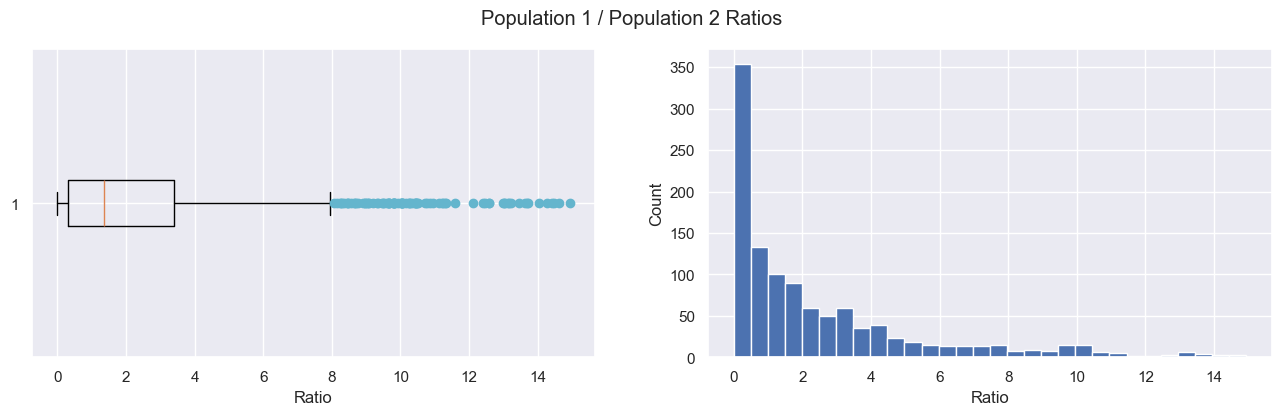

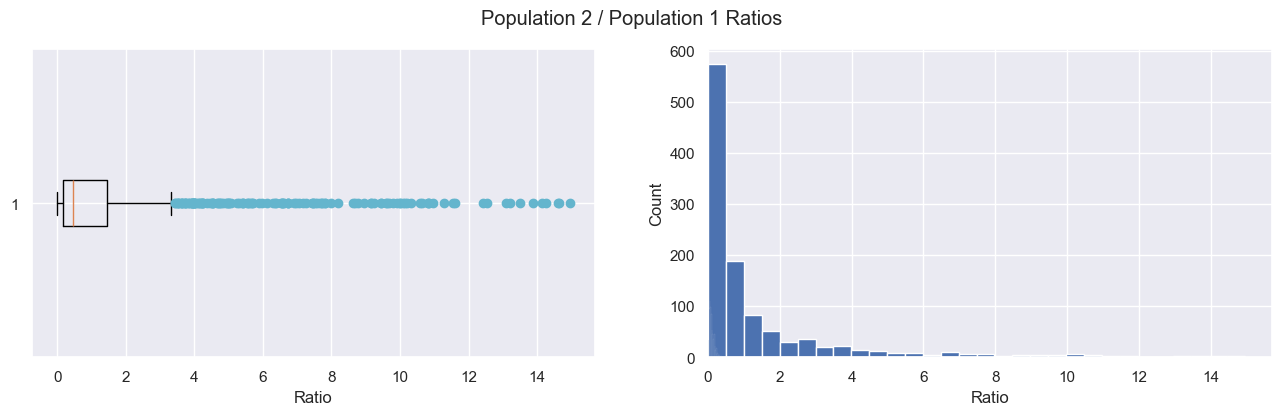

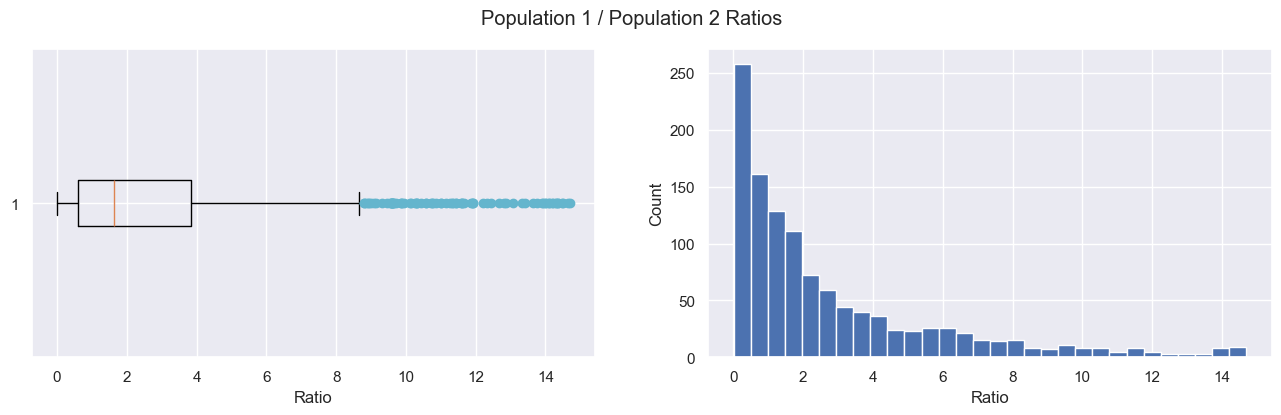

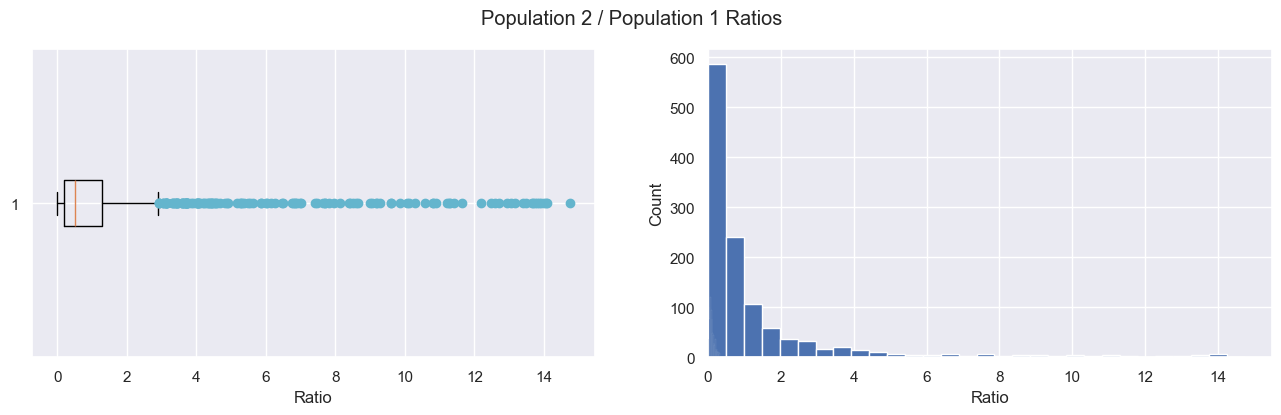

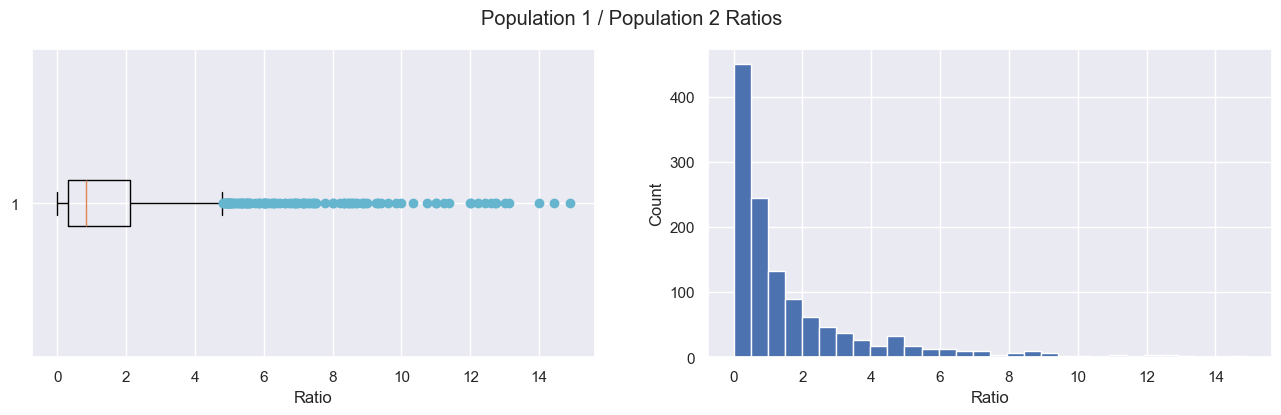

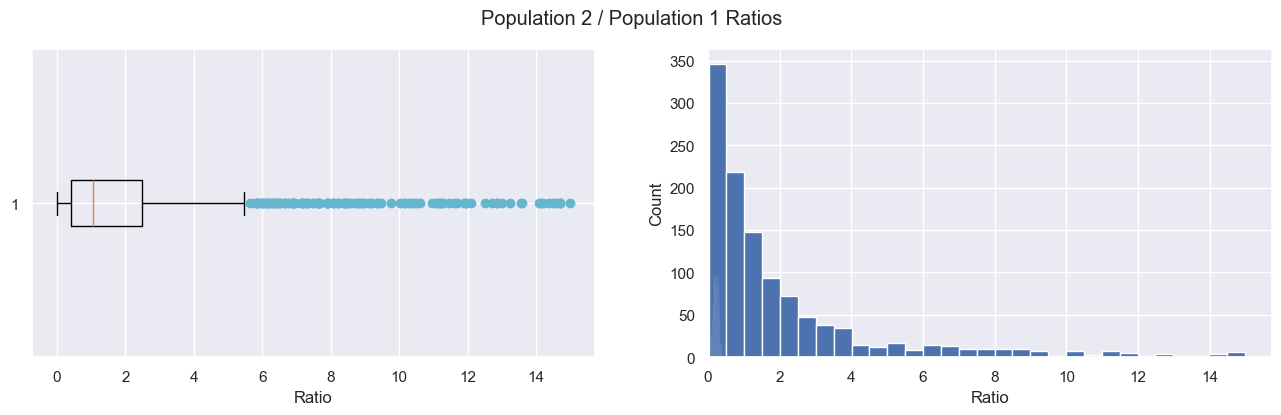

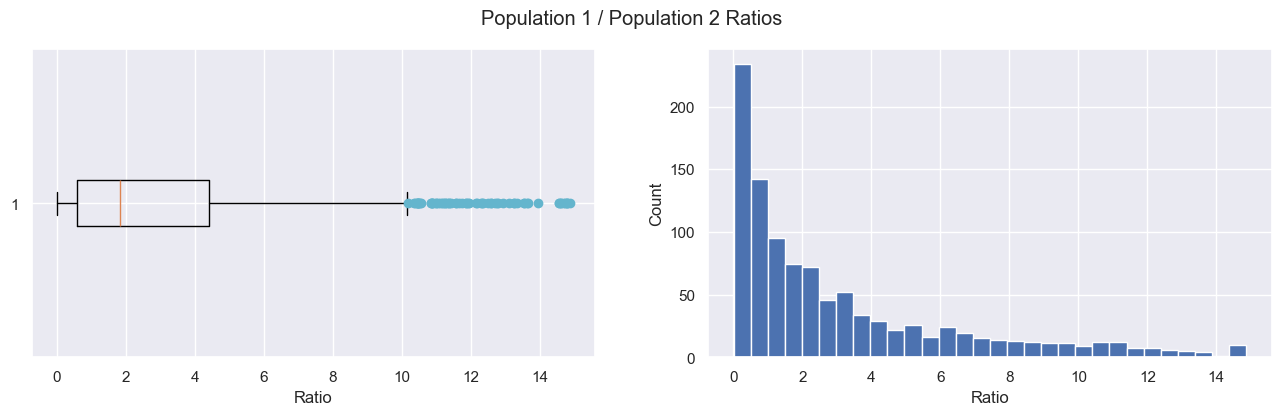

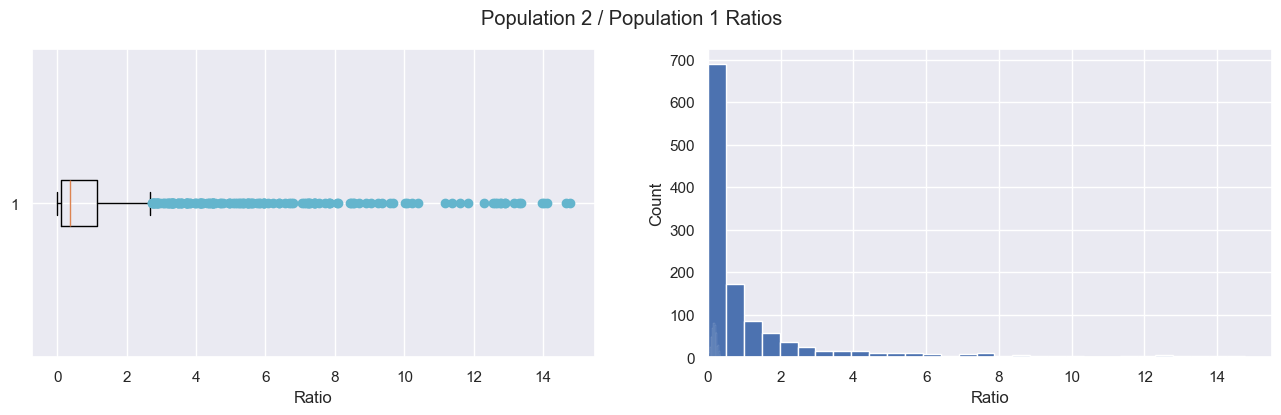

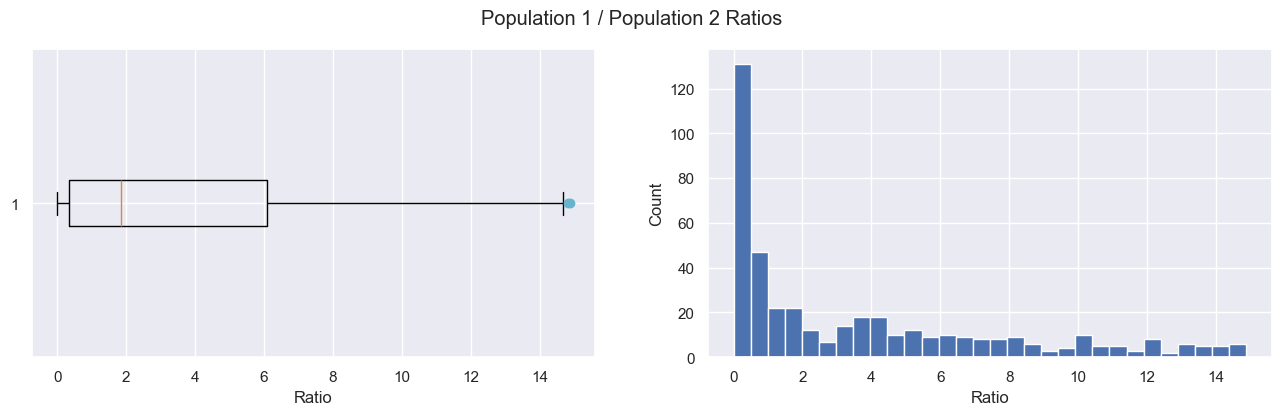

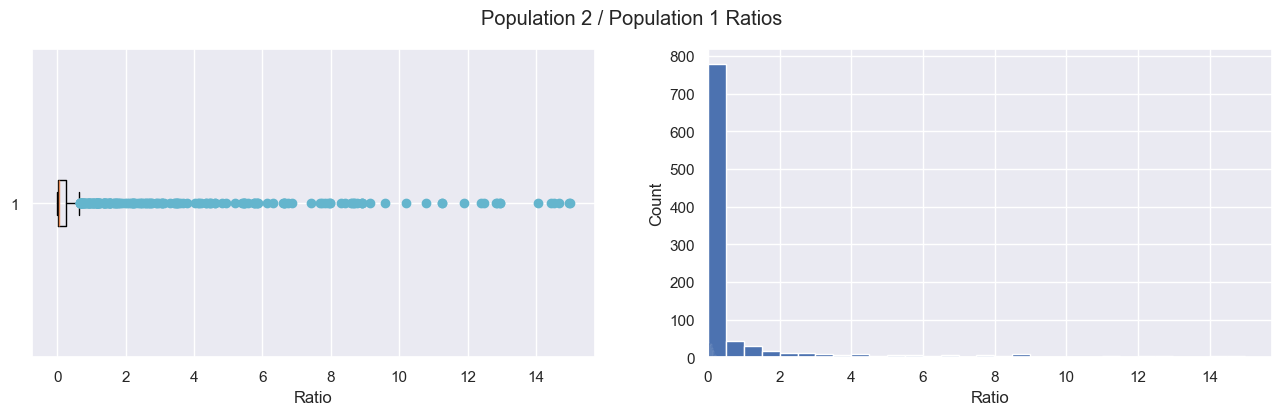

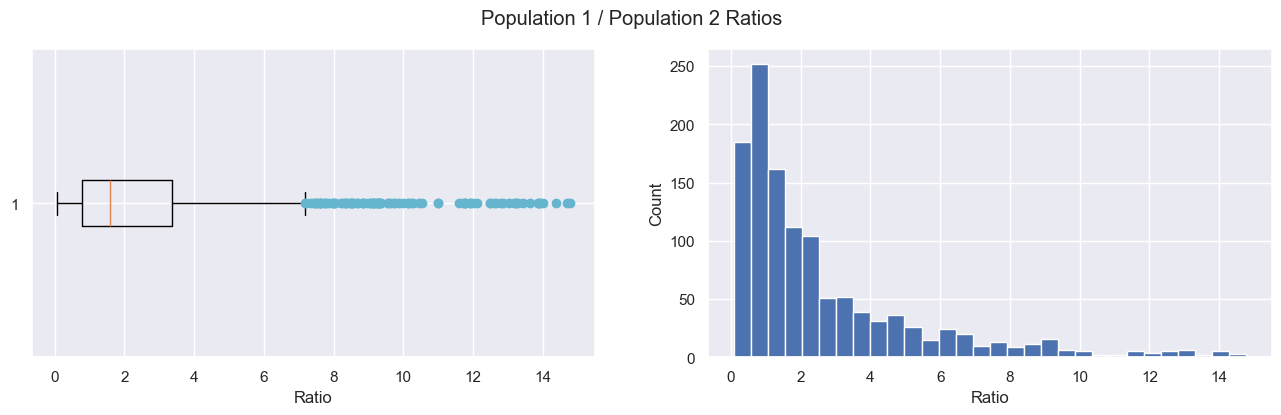

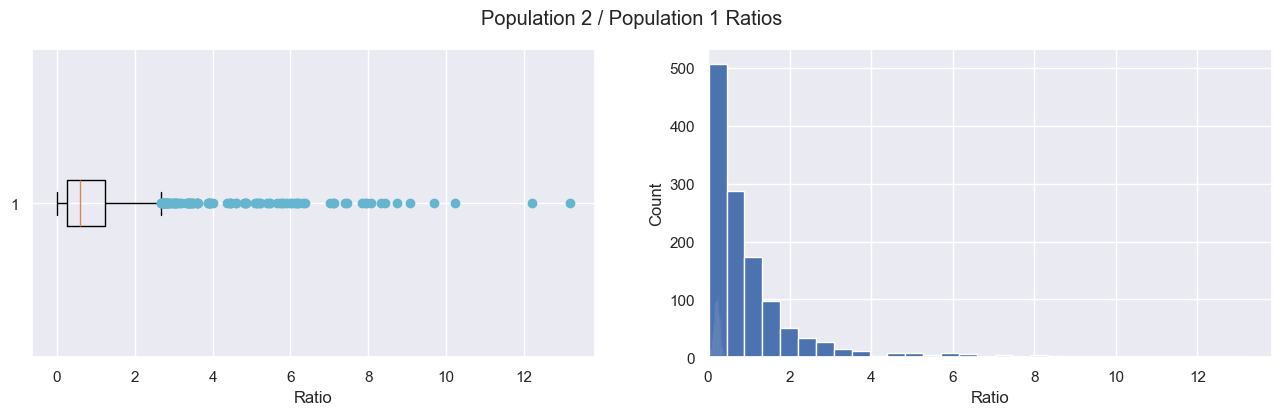

In [23]:
file_name = f"{mixing_type}_mixing_scores.csv"

pops = {'Cancer_Immune': (['Cancer'], ['T', 'B', 'Mono_Mac', 'NK', 'Granulocyte']),
        'Cancer_Structural': (['Cancer'], ['Structural']),
        'Structural_Immune': (['Structural'], ['T', 'B', 'Mono_Mac', 'NK', 'Granulocyte']),
        'Structural_T': (['Structural'], ['T']), 'Structural_B': (['Structural'], ['B']),
        'Structural_Mono_Mac': (['Structural'], ['Mono_Mac'])
        }


bins = 30
ratio_threshold = 5
cell_count_threshold = 200
all_mixing_scores = []

for mixing_prefix, cells in zip(pops.keys(), pops.values()):
    print(mixing_prefix)
    population_1_cells, population_2_cells = cells
    
    misc_utils.verify_in_list(provided_cell_populations=population_1_cells + population_2_cells, 
                          cell_populations_in_fov=all_data[cell_type_col].unique())

    ratios = compute_cell_ratios(neighbor_counts, population_1_cells, population_2_cells, 
                             fov_list=all_fovs, bin_number=bins, cell_col=cell_type_col)
    ratios = ratios.rename(columns={'cell_ratio': f'{mixing_prefix}_cell_ratio'})
    
    scores, counts = [], []
    for fov in all_fovs:
        fov_neighbor_counts = neighbor_counts[neighbor_counts[settings.FOV_ID] == fov]
        fov_score, cell_counts = compute_mixing_score(fov_neighbor_counts, population_1_cells, 
                                                      population_2_cells, mixing_type, 
                                                      ratio_threshold, cell_count_threshold, cell_col=cell_type_col)
        scores.append(fov_score)
        counts.append(cell_counts)

    mixing_score_data = pd.DataFrame(list(zip(all_fovs, scores, counts)), 
                                     columns =['fov', f'{mixing_prefix}_mixing_score', f'{mixing_prefix}_cell_count'])
    mixing_score_data = mixing_score_data.merge(ratios, on=['fov'])
    if mixing_prefix == 'Cancer_Immune':
        all_mixing_scores = mixing_score_data
    else:
        all_mixing_scores = all_mixing_scores.merge(mixing_score_data, on=['fov'])

    seaborn.set(rc={'figure.figsize': (8, 5)})
    p = seaborn.histplot(mixing_score_data, x=f'{mixing_prefix}_mixing_score').set(xlim=(0, None))
    
all_mixing_scores.to_csv(os.path.join(mixing_score_dir, file_name), index=False)